In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import en_core_web_md
import csv
import regex as re
import os

In [2]:
# Load up the files
path = './DataUCSB/'
list_of_files = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.txt'):
            list_of_files.append(os.path.join(root,file))

filepath = './DataUCSB/address-before-joint-session-the-congress-the-state-the-union-16.csv'
speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    speeches.append(text)

<A HREF="https://regexr.com/">Regexr</A>

In [33]:
# take out stuff like [Laughter] and [applause] and [Obama signs document]
speeches = [re.sub('\[.+?\]', '',speech) for speech in speeches]
# take out -- between words and replace with a space
speeches = [re.sub('\-\-', ' ',speech) for speech in speeches]

In [35]:
speechlist = [sentence.lstrip().rstrip() for sentence in speeches[67].split('.')]
lengths = [len(sentence.split(' ')) for sentence in speechlist]

In [36]:
speechlist = [sentence.lstrip().rstrip() for sentence in speeches[87].split('.')]
lengths2 = [len(sentence.split(' ')) for sentence in speechlist]

<A HREF="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html">Matplotlib docs</A>

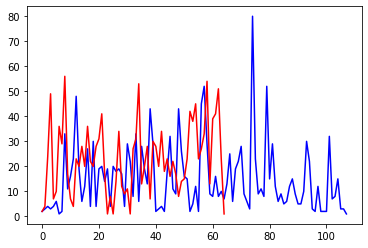

In [37]:
plt.plot(lengths, 'b')
plt.plot(lengths2, 'r')
plt.show()

In [26]:
print('mean %s and stdev %s of speech 67' %(round(np.average(lengths),3), round(np.std(lengths),3)))

mean 15.037 and stdev 13.531 of speech 67


In [27]:
print('mean %s and stdev %s of speech 87' %(round(np.average(lengths2),3), round(np.std(lengths2),3)))

mean 23.062 and stdev 14.149 of speech 87


<A HREF="https://matplotlib.org/stable/gallery/statistics/hist.html">Matplotlib histograms</A>

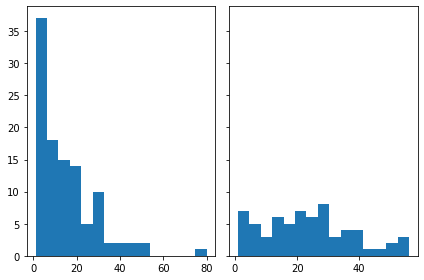

In [28]:
n_bins=15
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(lengths, bins=n_bins)
axs[1].hist(lengths2, bins=n_bins)
plt.show()

<A HREF="https://datascience.stackexchange.com/questions/23376/how-to-get-the-number-of-syllables-in-a-word">Counting syllables</A>

In [9]:
def syllables(word):
    #referred from stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return count

<P>In a cmd/terminal window </P>
<P>>python</P>
<P>>>> import nltk</P>
<P>>>> nltk.download()</P>
<P>This opens a window from which you can download various corpora and dictionaries from NLTK</P>


In [10]:
import nltk
from nltk.corpus import cmudict
d = cmudict.dict()

In [11]:
def nsyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    except KeyError:
        #if word not found in cmudict
        return syllables(word)

<A HREF="https://spacy.io/universe/project/spacy_syllables">Spacy Syllables</A>

In [ ]:
!pip install spacy_syllables

In [12]:
import spacy
from spacy_syllables import SpacySyllables

In [13]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("syllables", after="tagger")

assert nlp.pipe_names == ["tok2vec", "tagger", "syllables", "parser",  "attribute_ruler", "lemmatizer", "ner"]
doc = nlp(speeches[87])
data = [(token.text, token._.syllables, token._.syllables_count) for token in doc]
# punctuation returns None, skip those
[i[2] for i in data if i[2]!=None]

[1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 6,
 2,
 1,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 1,
 3,
 1,
 1,
 4,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 2,
 5,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 3,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 3,
 2,
 1,
 4,
 4,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 3,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 5,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,


In [14]:
data

[('Thank', ['thank'], 1),
 ('you', ['you'], 1),
 ('.', None, None),
 ('Well', ['well'], 1),
 (',', None, None),
 ('I', ['i'], 1),
 ("'m", None, None),
 ('excited', ['ex', 'cit', 'ed'], 3),
 ('too', ['too'], 1),
 ('.', None, None),
 ('[', None, None),
 ('Laughter', ['laugh', 'ter'], 2),
 (']', None, None),
 ('Of', ['of'], 1),
 ('the', ['the'], 1),
 ('many', ['many'], 1),
 ('responsibilities', ['re', 'spon', 'si', 'bil', 'i', 'ties'], 6),
 ('granted', ['grant', 'ed'], 2),
 ('to', ['to'], 1),
 ('a', ['a'], 1),
 ('President', ['pres', 'i', 'dent'], 3),
 ('by', ['by'], 1),
 ('our', ['our'], 1),
 ('Constitution', ['con', 'sti', 'tu', 'tion'], 4),
 (',', None, None),
 ('few', ['few'], 1),
 ('are', ['are'], 1),
 ('more', ['more'], 1),
 ('serious', ['se', 'ri', 'ous'], 3),
 ('or', ['or'], 1),
 ('more', ['more'], 1),
 ('consequential', ['con', 'se', 'quen', 'tial'], 4),
 ('than', ['than'], 1),
 ('selecting', ['se', 'lect', 'ing'], 3),
 ('a', ['a'], 1),
 ('Supreme', ['supreme'], 1),
 ('Court', ['